Compare the feature embeddings of samples
* with Pneumonia only
* with Pneumonia and other diseases
* with No Findings

In [85]:
import os
import base64
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import sys
sys.path.append("/mnt/data2/datasets_lfay/MedImageInsights")
from MedImageInsight.medimageinsightmodel import MedImageInsight


In [86]:
# Step 1: Load model
PATH_TO_DATA = "/mnt/data2/datasets_lfay/MedImageInsights/data"
MODEL_DIR = "/mnt/data2/datasets_lfay/MedImageInsights/MedImageInsight/2024.09.27"

# Load your MedImageInsight classifier
classifier = MedImageInsight(
    model_dir=MODEL_DIR,
    vision_model_name="medimageinsigt-v1.0.0.pt",
    language_model_name="language_model.pth"
)
classifier.load_model()

Model loaded successfully on device: cuda


In [87]:
# Step 2: Load test data
dataset = "MIMIC-v1.0-512"
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, dataset, "test.csv"))


In [88]:
# Step 3: Dataset Configuration
datasets = {
    "MIMIC": {
        "path": PATH_TO_DATA + "/MIMIC-v1.0-512/",
        "diseases": ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
                     'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                     'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
                     'Support Devices']
    },
    "CheXpert": {
        "path": PATH_TO_DATA + "/CheXpert-v1.0-512/",
        "diseases": ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
                     'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                     'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
                     'Support Devices']
    },
    "VinDR": {
        "path": PATH_TO_DATA + "/vindr-pcxr/",
        "diseases": ['No Finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia', 'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema', 'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor', 'Lung tumor']
    }
}

In [89]:
# Step 4: Function to Extract and Process Data
def extract_and_process_data(dataset_name, dataset_config):
    print(f"Processing dataset: {dataset_name}")
    dataset = dataset_config["path"].split("/")[-2]
    diseases = dataset_config["diseases"]

    # Load the dataset
    df_test = pd.read_csv(os.path.join(dataset_config["path"], "test.csv"))

    # Filter "Pneumonia Only" and "Pneumonia + Diseases"
    single_disease = diseases.copy()
    single_disease.remove("Pneumonia")

    pneumonia_only = df_test[(df_test["Pneumonia"] == 1) & (df_test[single_disease] == 0).all(axis=1)]
    pneumonia_plus = df_test[(df_test["Pneumonia"] == 1) & (df_test[single_disease].sum(axis=1) > 0)]

    combined_test = pd.concat([pneumonia_plus, pneumonia_only], ignore_index=True)
    labels = ["Pneumonia + Diseases"] * len(pneumonia_plus)+["Pneumonia Only"] * len(pneumonia_only)

    # Extract embeddings
    embeddings = []
    for _, row in tqdm(combined_test.iterrows(), total=len(combined_test), desc=f"Extracting embeddings for {dataset_name}"):
        image_path = dataset_config["path"].split("/data/")[0]+"/data"+row["Path"]
        with open(image_path, "rb") as img_file:
            image_base64 = base64.encodebytes(img_file.read()).decode("utf-8")
        embedding = classifier.encode(images=[image_base64])["image_embeddings"]
        embeddings.append(embedding[0])  # Append the first embedding

    return np.array(embeddings), labels

In [90]:
# Step 5: Process All Datasets
all_embeddings = {}
for dataset_name, dataset_config in datasets.items():
    embeddings, labels = extract_and_process_data(dataset_name, dataset_config)
    all_embeddings[dataset_name] = {
        "embeddings": embeddings,
        "labels": labels
    }

Processing dataset: MIMIC


Extracting embeddings for MIMIC: 100%|██████████| 4093/4093 [04:08<00:00, 16.47it/s]


Processing dataset: CheXpert


Extracting embeddings for CheXpert: 100%|██████████| 1254/1254 [01:14<00:00, 16.78it/s]


Processing dataset: VinDR


Extracting embeddings for VinDR: 100%|██████████| 89/89 [00:07<00:00, 12.69it/s]


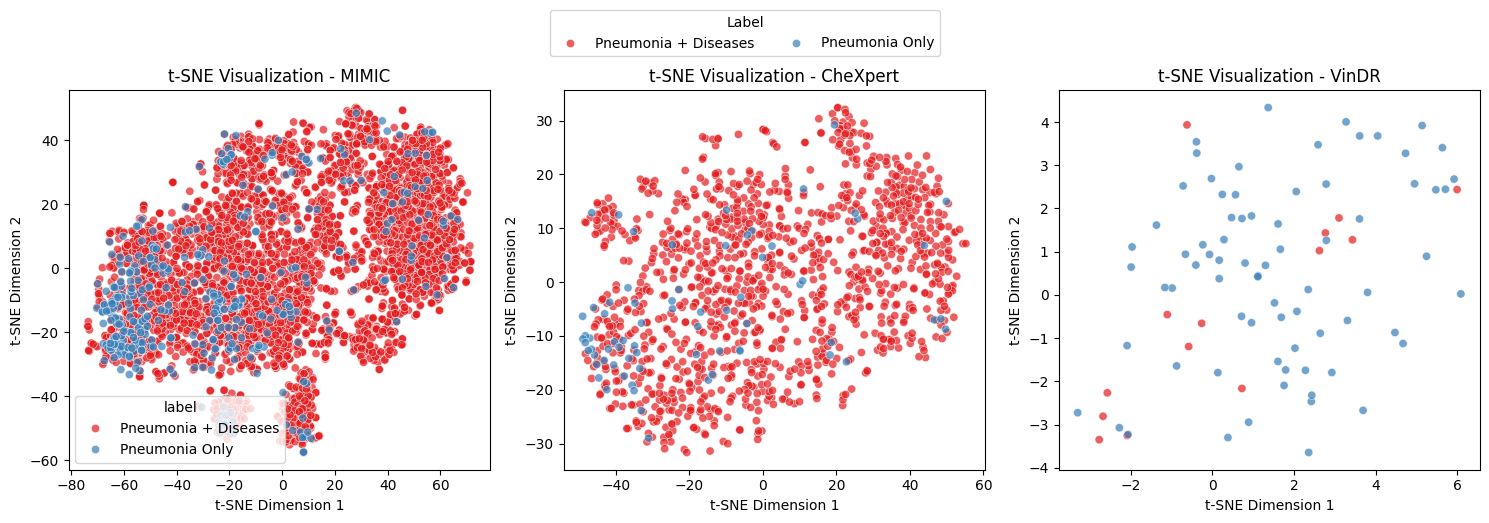

In [98]:

# Step 6: Perform t-SNE and Visualize
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, (dataset_name, data) in enumerate(all_embeddings.items()):
    embeddings_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000).fit_transform(data["embeddings"])
    tsne_df = pd.DataFrame(embeddings_2d, columns=["x", "y"])
    tsne_df["label"] = data["labels"]

    # Plot for each dataset
    sns.scatterplot(ax=axes[i], data=tsne_df, x="x", y="y", hue="label", alpha=0.7, palette="Set1")
    axes[i].set_title(f"t-SNE Visualization - {dataset_name}")
    axes[i].set_xlabel("t-SNE Dimension 1")
    axes[i].set_ylabel("t-SNE Dimension 2")
    axes[i].legend(title="Label", loc="best")

plt.tight_layout()
plt.show()


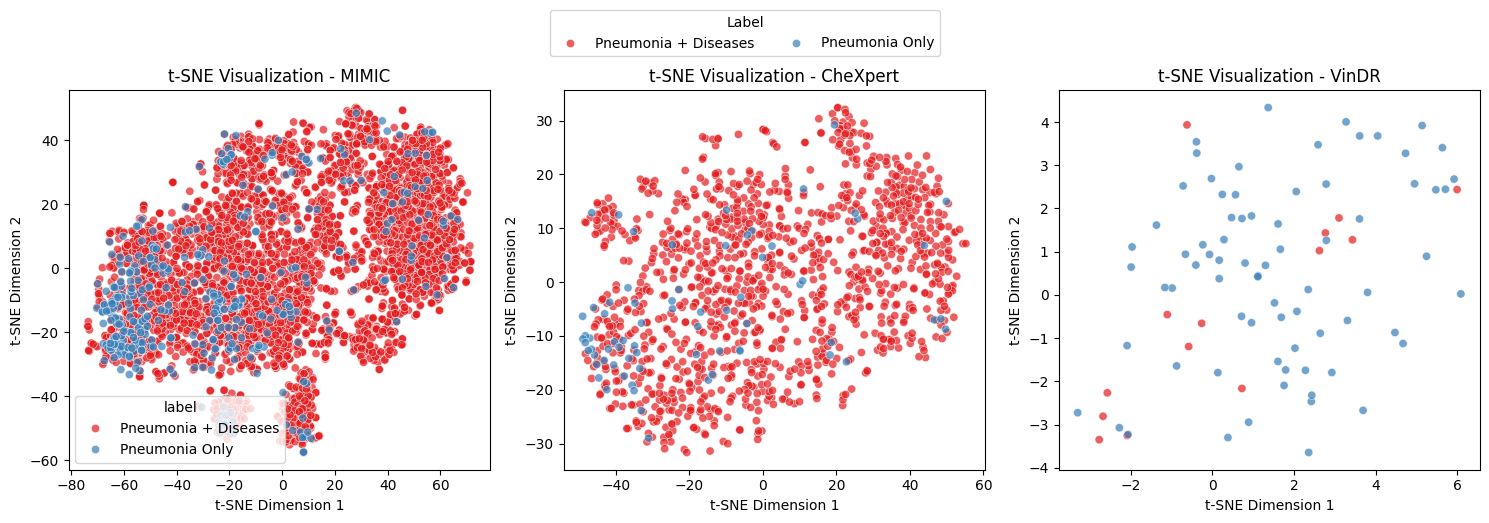

In [99]:
# Step 6: Perform t-SNE and Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # No shared axes for differing scales

for i, (dataset_name, data) in enumerate(all_embeddings.items()):
    # Perform t-SNE
    embeddings_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000).fit_transform(data["embeddings"])
    tsne_df = pd.DataFrame(embeddings_2d, columns=["x", "y"])
    tsne_df["label"] = data["labels"]

    # Plot for each dataset
    scatter = sns.scatterplot(ax=axes[i], data=tsne_df, x="x", y="y", hue="label", alpha=0.7, palette="Set1")
    axes[i].set_title(f"t-SNE Visualization - {dataset_name}")
    axes[i].set_xlabel("t-SNE Dimension 1")
    axes[i].set_ylabel("t-SNE Dimension 2")

    # Remove individual legends
    if i > 0:
        axes[i].legend_.remove()

# Add a single legend outside the subplots
handles, labels = scatter.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, title="Label")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend
plt.show()


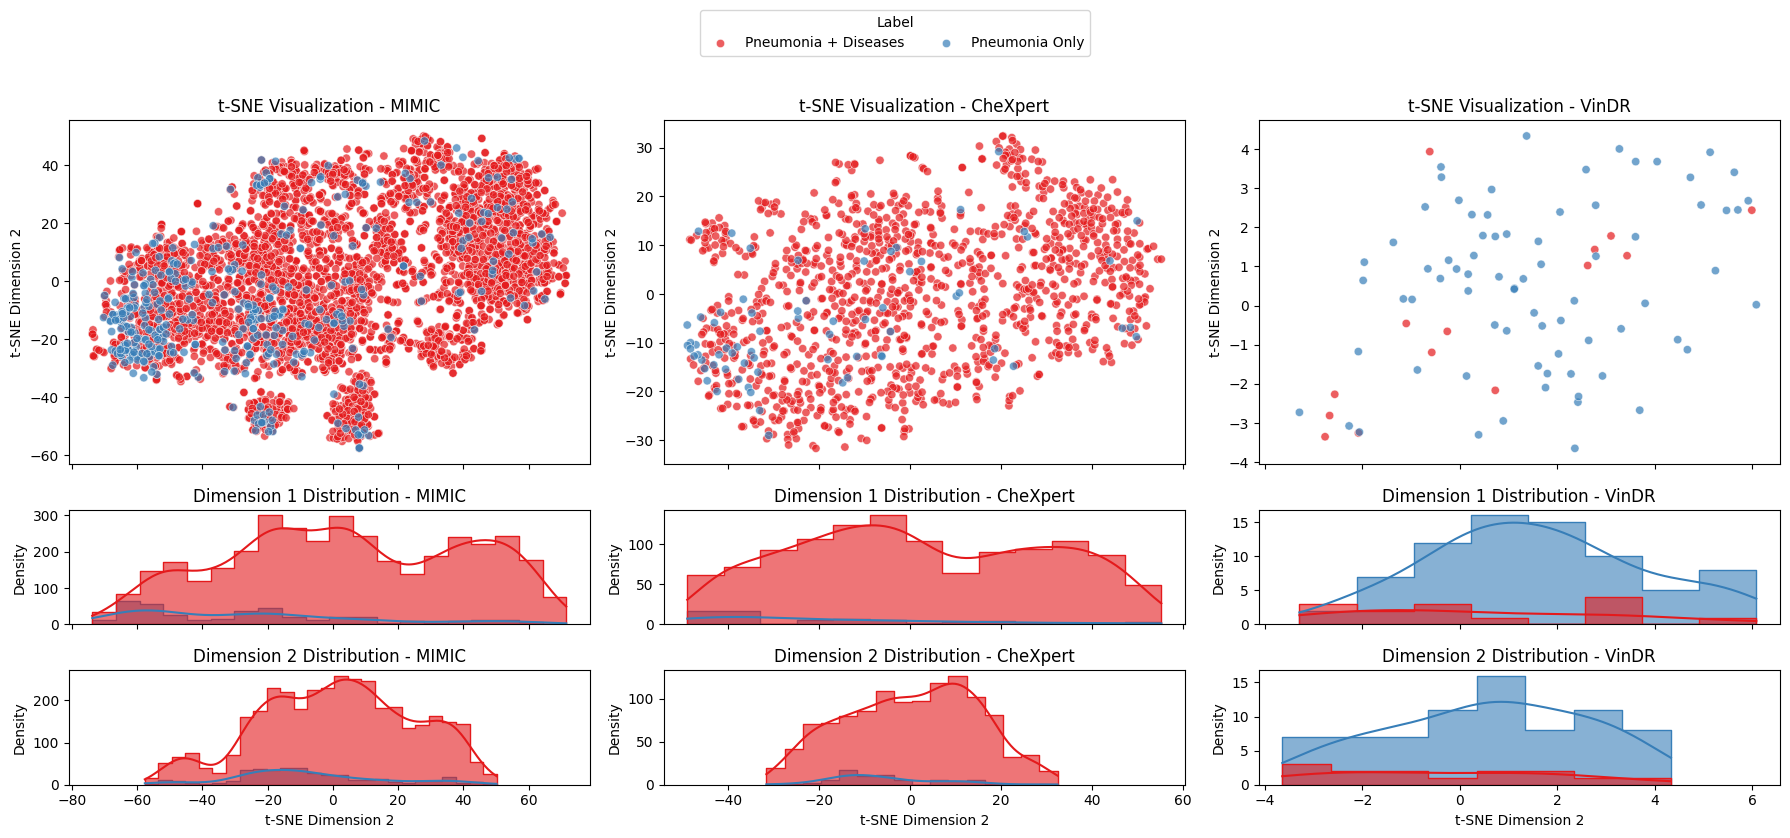

In [103]:
# Step 6: Perform t-SNE and Visualize
fig, axes = plt.subplots(3, 3, figsize=(18, 8), gridspec_kw={"height_ratios": [3,1, 1]}, sharex="col")

for i, (dataset_name, data) in enumerate(all_embeddings.items()):
    # Perform t-SNE
    embeddings_2d = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000).fit_transform(data["embeddings"])
    tsne_df = pd.DataFrame(embeddings_2d, columns=["x", "y"])
    tsne_df["label"] = data["labels"]

    # Top row: Scatter plot for each dataset
    scatter = sns.scatterplot(ax=axes[0, i], data=tsne_df, x="x", y="y", hue="label", alpha=0.7, palette="Set1")
    axes[0, i].set_title(f"t-SNE Visualization - {dataset_name}")
    axes[0, i].set_xlabel("t-SNE Dimension 1")
    axes[0, i].set_ylabel("t-SNE Dimension 2")



    # Bottom row: 1D Distribution plot for Dimension 1
    sns.histplot(ax=axes[1, i], data=tsne_df, x="x", hue="label", kde=True, palette="Set1", alpha=0.6, element="step")
    axes[1, i].set_title(f"Dimension 1 Distribution - {dataset_name}")
    axes[1, i].set_xlabel("t-SNE Dimension 1")
    axes[1, i].set_ylabel("Density")

    sns.histplot(ax=axes[2, i], data=tsne_df, x="y", hue="label", kde=True, palette="Set1", alpha=0.6, element="step")
    axes[2, i].set_title(f"Dimension 2 Distribution - {dataset_name}")
    axes[2, i].set_xlabel("t-SNE Dimension 2")
    axes[2, i].set_ylabel("Density")  

    # Remove individual legends for scatter plots
 
    axes[0, i].legend_.remove()
    axes[1, i].legend_.remove()
    axes[2, i].legend_.remove()

# Add a single legend for all subplots
handles, labels = scatter.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, title="Label")

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
